In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

In [2]:
train = pd.read_csv('ml_training_clean.csv')
history_data = pd.read_csv('ml_history_clean.csv')

# Feature Engineering

Since we have the consumption data for each of the companies for the year 2015, we will create new features using the average of the year, the
last six months, and the last three months to our model.

In [3]:
mean_year = history_data.groupby(["id"]).mean(numeric_only=True).reset_index()

In [4]:
mean_6m = history_data[history_data["price_date"] > "2015-06-01"].groupby(["id"]).mean(numeric_only=True).reset_index()

In [5]:
mean_3m = history_data[history_data["price_date"] > "2015-10-01"].groupby(["id"]).mean(numeric_only=True).reset_index()

### Combine them in a single dataframe


In [6]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
"price_p2_var": "mean_year_price_p2_var",
"price_p3_var": "mean_year_price_p3_var",
"price_p1_fix": "mean_year_price_p1_fix",
"price_p2_fix": "mean_year_price_p2_fix",
"price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [7]:
mean_6m = mean_6m.rename(index=str, columns={"price_p1_var": "mean_6m_price_p1_var",
"price_p2_var": "mean_6m_price_p2_var",
"price_p3_var": "mean_6m_price_p3_var",
"price_p1_fix": "mean_6m_price_p1_fix",
"price_p2_fix": "mean_6m_price_p2_fix",
"price_p3_fix": "mean_6m_price_p3_fix",})
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"]
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"]
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]

In [8]:
mean_3m = mean_3m.rename(index=str, columns={"price_p1_var": "mean_3m_price_p1_var",
"price_p2_var": "mean_3m_price_p2_var",
"price_p3_var": "mean_3m_price_p3_var",
"price_p1_fix": "mean_3m_price_p1_fix",
"price_p2_fix": "mean_3m_price_p2_fix",
"price_p3_fix": "mean_3m_price_p3_fix",})
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"]
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"]
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]

In [9]:
#features = pd.merge(mean_year,mean_6m, on="id")
#features = pd.merge(features,mean_3m, on="id")
features = mean_year

Feature engineering
In the previous notebook we explored the data and made a deep dive into the churn by dates. Nonetheless, that exploration was quite shallow and did
not provide us with any relevant insight.
What if we could create a new variable that could provide us more relevant insights?

We will define a variable tenure = date_end - date_activ

In [10]:
# Convert to datetime format
train["date_end"] = pd.to_datetime(train["date_end"])
train["date_activ"] = pd.to_datetime(train["date_activ"])

# Compute tenure in years
train["tenure"] = ((train["date_end"] - train["date_activ"]).dt.days/365.25).astype(int)

In [11]:
tenure = train[["tenure", "churn", "id"]].groupby(["tenure", "churn"])["id"].count().unstack(level=1)
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

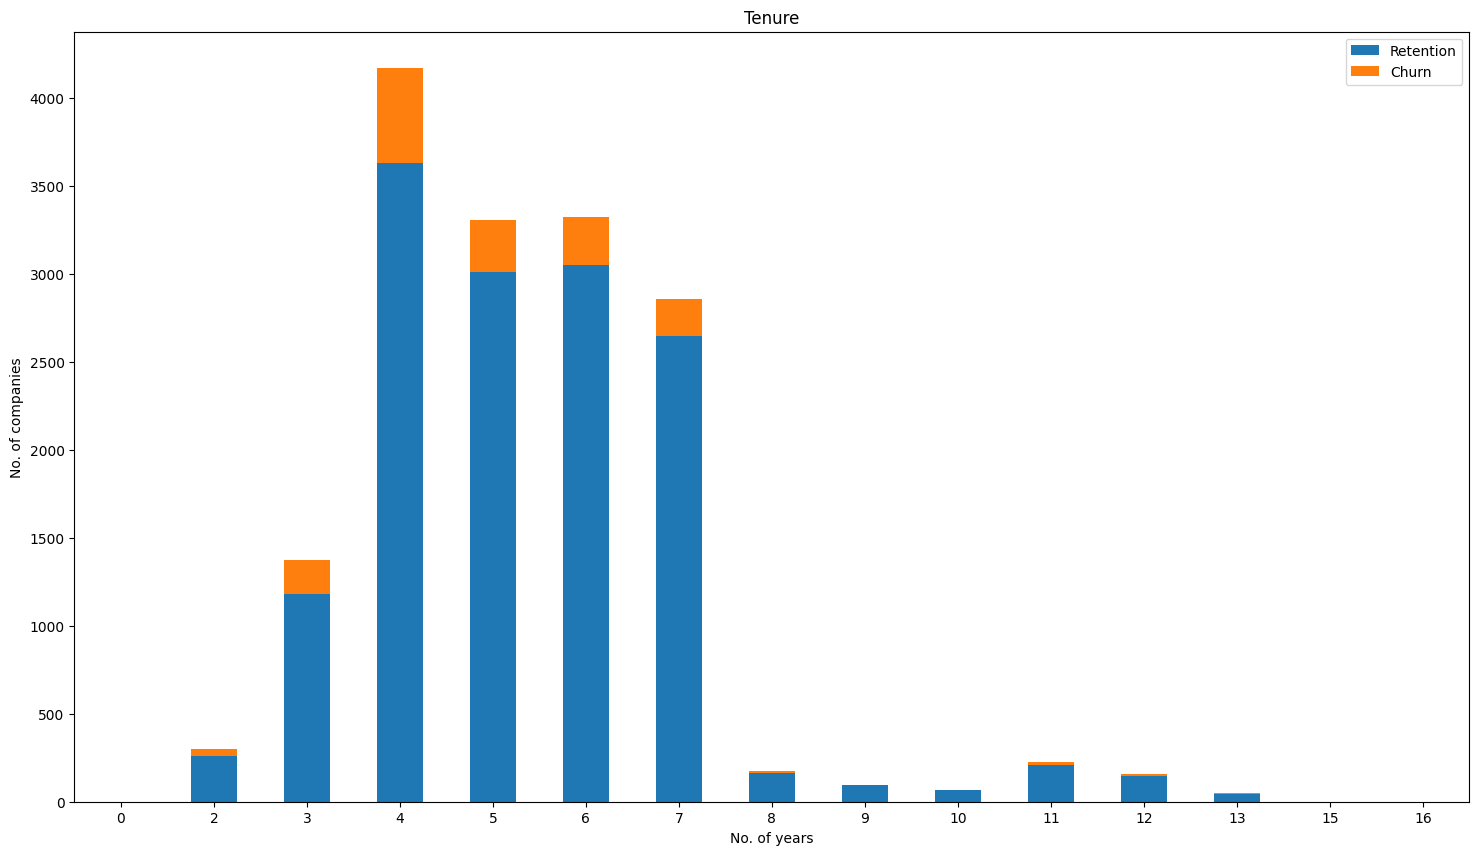

In [12]:
tenure.plot(kind="bar",
figsize=(18,10),
stacked=True,
rot=0,
title= "Tenure")
# Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")
# Labels
plt.ylabel("No. of companies")
plt.xlabel("No. of years")
plt.show()

We can clearly see that churn is very low for companies that joined recently or have had a contract for a long time. However, there is a higher number of churners within the 3–7 years of tenure.

Define the following dates:

months_activ : Number of months active until reference date (Jan 2016)

months_to_end : Number of months of the contract left at reference date (Jan 2016)

months_modif_prod : Number of months since last modification at reference date (Jan 2016)

months_renewal : Number of months since last renewal at reference date (Jan 2016)

In [13]:
#Create reference date as provided on the exercise statement
REFERENCE_DATE = datetime.datetime(2016,1,1)

In [14]:
def convert_months(reference_date, dataframe, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = REFERENCE_DATE - dataframe[column]
    months = (time_delta.dt.days / 30.44).astype(int)
    return months

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                16096 non-null  int64         
 1   id                        16096 non-null  object        
 2   activity_new              6551 non-null   object        
 3   channel_sales             16096 non-null  object        
 4   cons_12m                  16096 non-null  int64         
 5   cons_gas_12m              16096 non-null  int64         
 6   cons_last_month           16096 non-null  int64         
 7   date_activ                16096 non-null  datetime64[ns]
 8   date_end                  16096 non-null  datetime64[ns]
 9   date_modif_prod           16096 non-null  object        
 10  date_renewal              16096 non-null  object        
 11  forecast_cons_12m         16096 non-null  float64       
 12  forecast_cons_year

In [16]:
train['date_modif_prod']=pd.to_datetime(train['date_modif_prod'])

In [17]:
train['date_renewal']=pd.to_datetime(train['date_renewal'])

In [18]:
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ")
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end")
train["months_modif_prod"] = convert_months(REFERENCE_DATE, train, "date_modif_prod")
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")

In [19]:
def plot_churn_by_month(dataframe, column, fontsize_=11):
    """
    Plot churn distribution by monthly variable
    """
    temp = dataframe[[column, "churn", "id"]].groupby([column, "churn"])["id"].count().unstack(level=1)
    temp.plot(kind="bar",
    figsize=(18,10),
    stacked=True,
    rot=0,
    title= column)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc="upper right")
    # Labels
    plt.ylabel("No. of companies")
    plt.xlabel("No. of months")
    # Set xlabel fontsize
    plt.xticks(fontsize=fontsize_)
    plt.show()

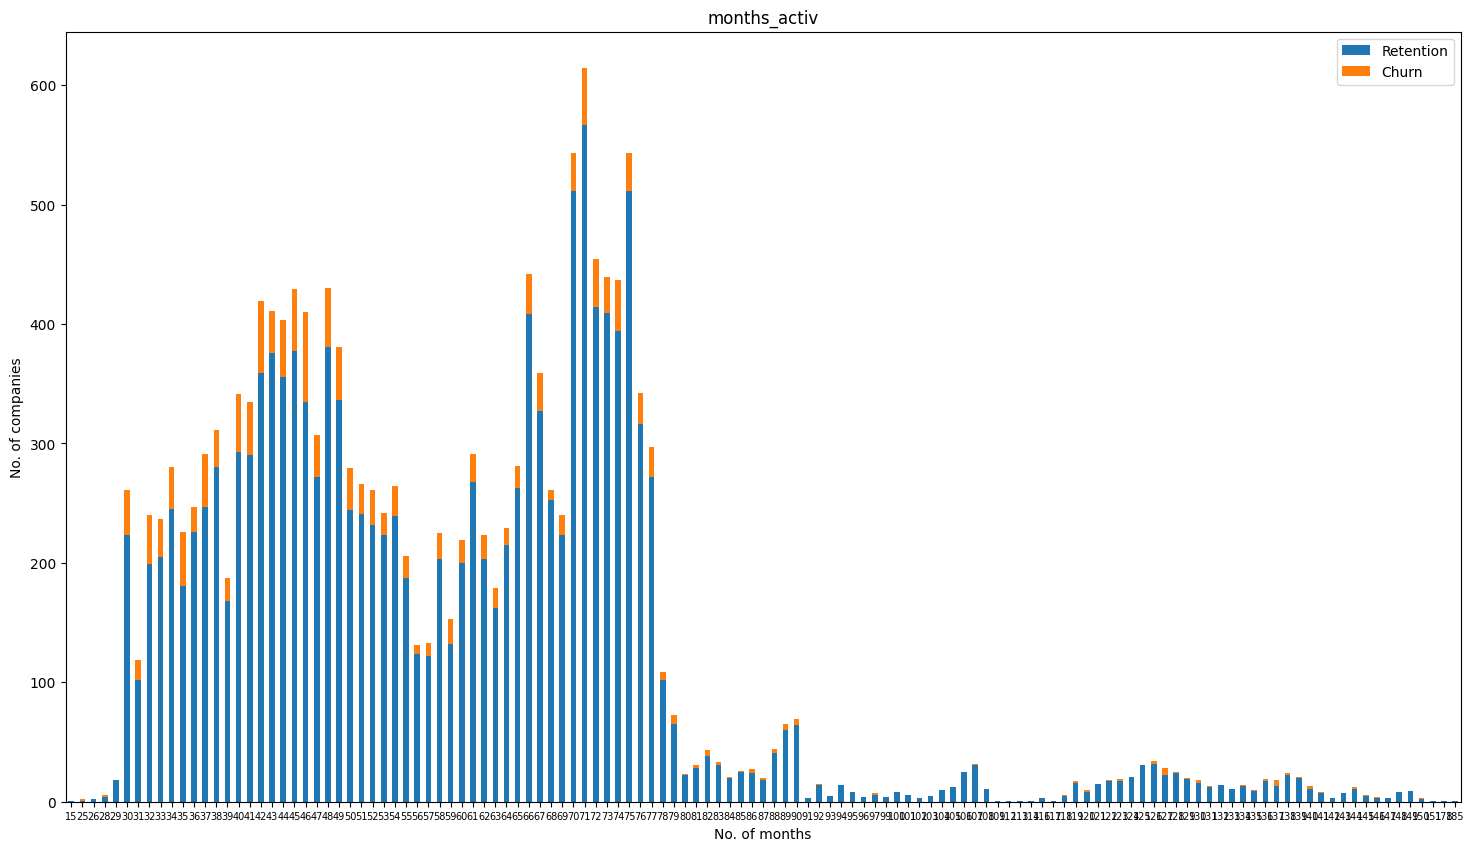

In [20]:
plot_churn_by_month(train, "months_activ", 7)

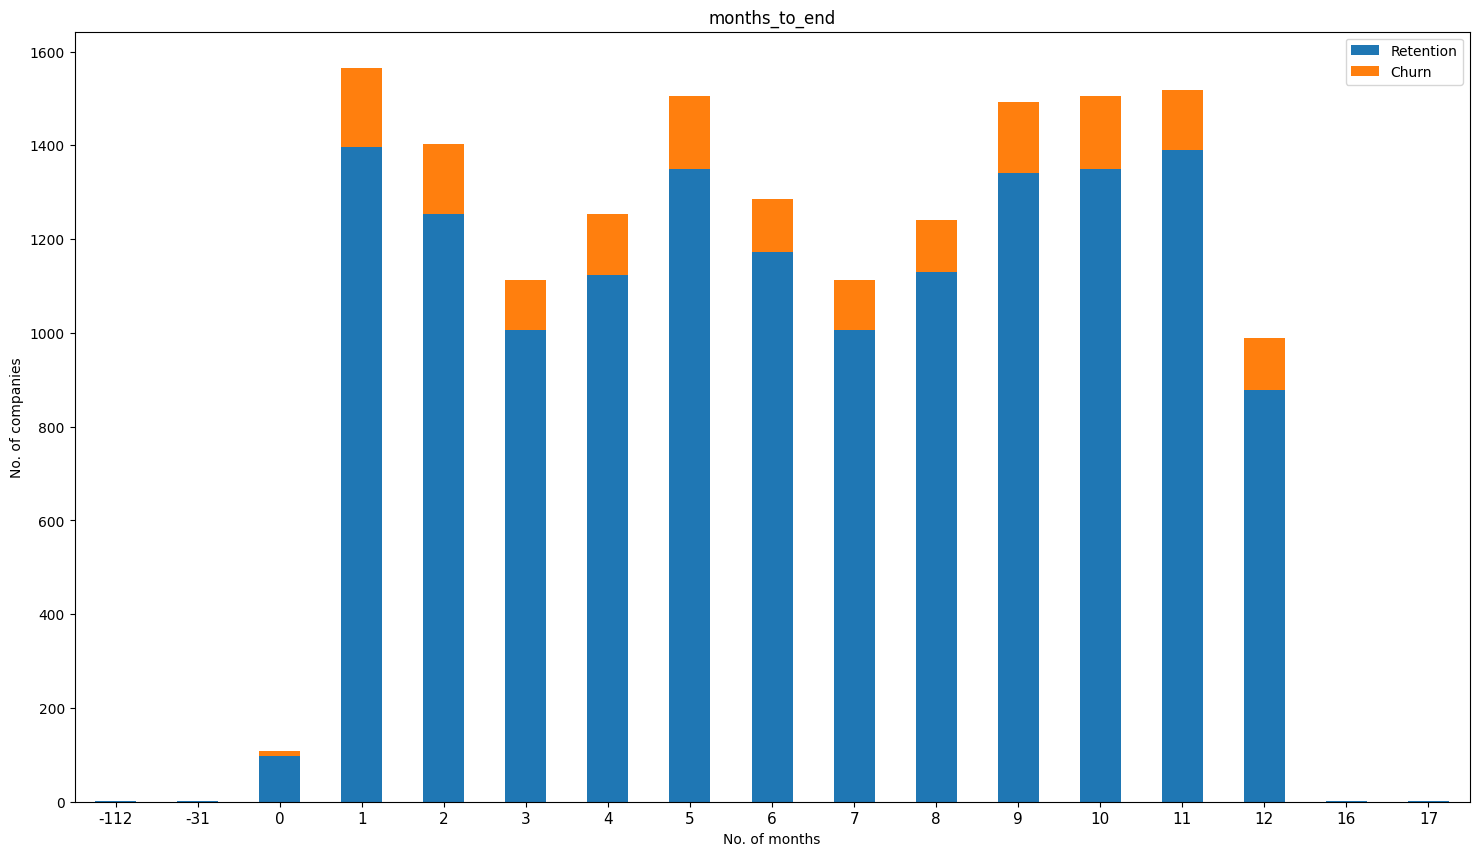

In [21]:
plot_churn_by_month(train, "months_to_end")

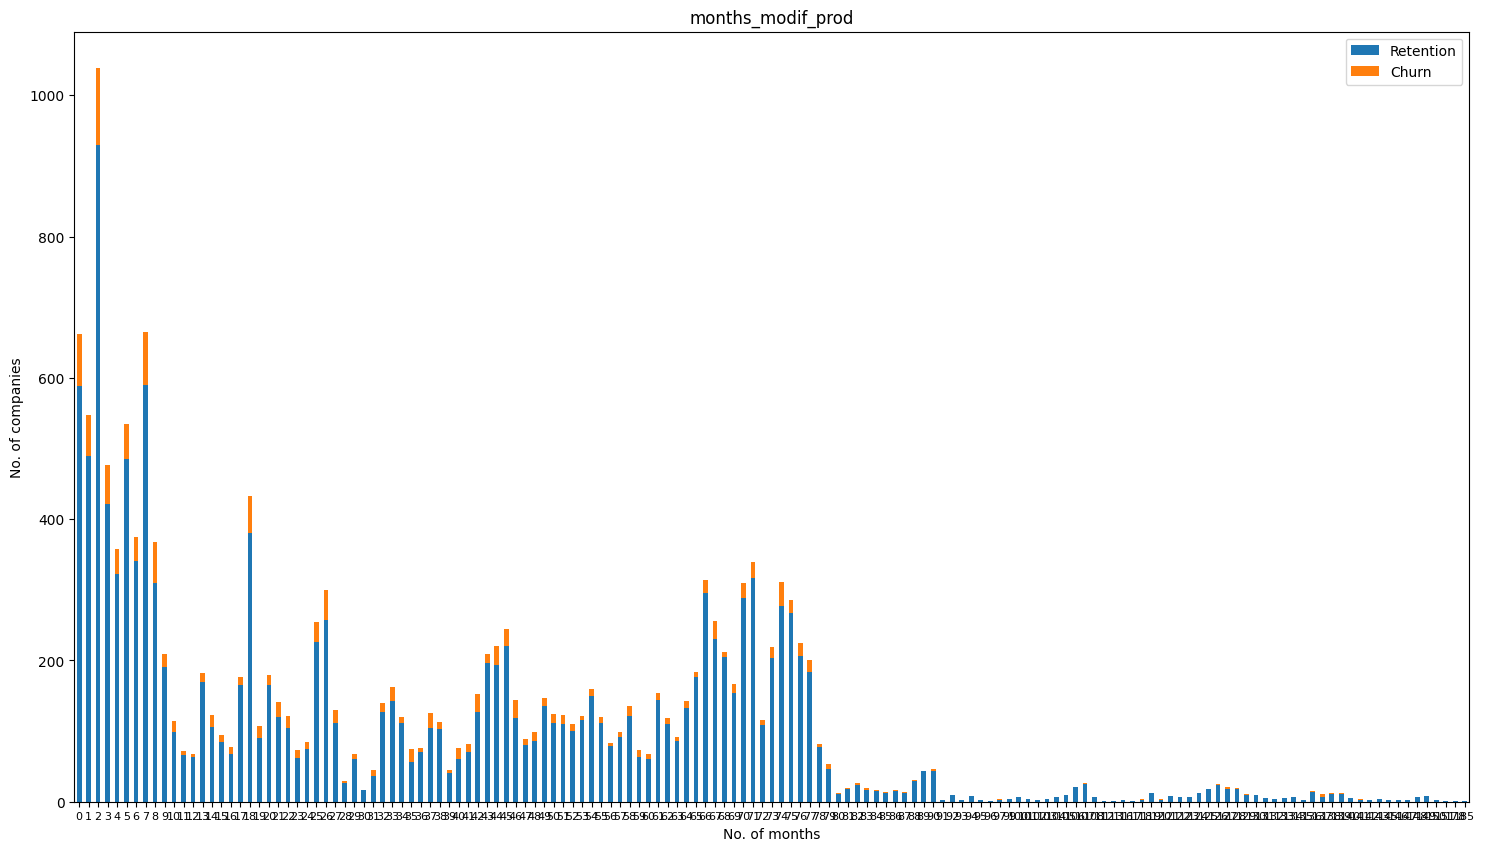

In [22]:
plot_churn_by_month(train, "months_modif_prod", 8)

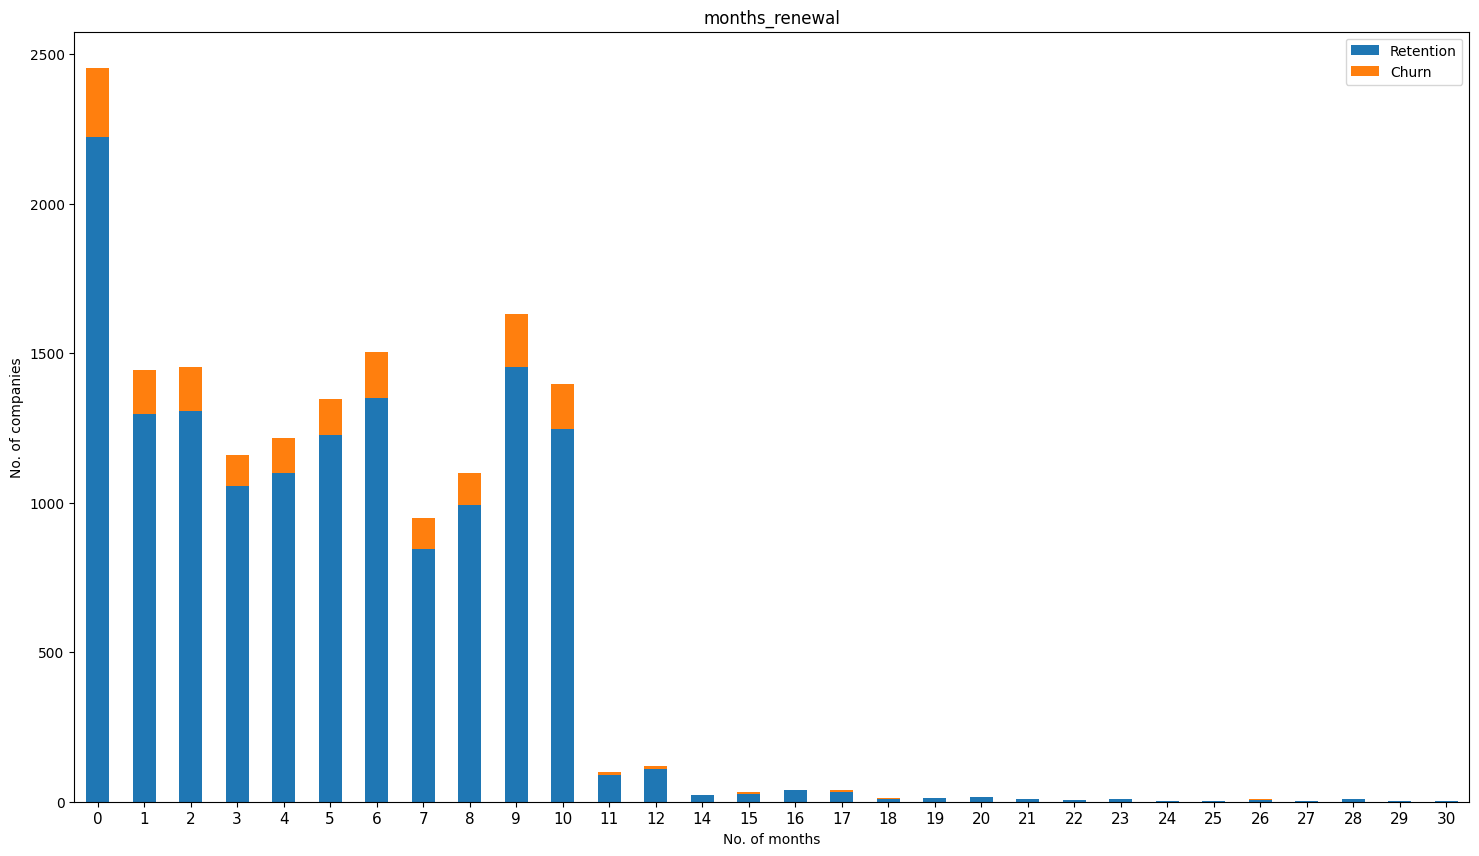

In [23]:
plot_churn_by_month(train, "months_renewal")

In [24]:
#Remove the date columns
train.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"],inplace=True)

### Transform boolean data
For the column has_gas, we will replace t for True or 1 and f for False or 0 . This process is usually referred as onehot encoding

In [25]:
train["has_gas"] = train["has_gas"].replace(["t", "f"], [1, 0]).astype(int)

C:\Users\tramn\AppData\Local\Temp\ipykernel_4780\2466158133.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train["has_gas"] = train["has_gas"].replace(["t", "f"], [1, 0]).astype(int)


### Categorical data and dummy variables

When training our model we cannot use string data as such, so we will need to encode it into numerical data. The easiest method is mapping
each category to an integer ( label encoding ) but this will not work because the model will misunderstand the data to be in some kind of order or
hierarchy, 0 < 1 < 2 < 3 ...

For that reason we will use a method with dummy variables or onehot encoder

Categorical data channel_sales
What we are doing here relatively simple, we want to convert each category into a new dummy variable which will have 0 s and 1 s depending
whether than entry belongs to that particular category or not
First of all let's replace the Nan values with a string called null_values_channel

In [26]:
train["channel_sales"] = train["channel_sales"].fillna("null_values_channel")

In [27]:
# Transform to categorical data type
train["channel_sales"] = train["channel_sales"].astype("category")

In [28]:
pd.DataFrame({"Samples in category": train["channel_sales"].value_counts()})

,Samples in category
channel_sales,
foosdfpfkusacimwkcsosbicdxkicaua,7377
Other,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [29]:
# Create dummy variables
categories_channel = pd.get_dummies(train["channel_sales"], prefix = "channel").astype(int)

In [30]:
# Rename columns for simplicity
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]

In [31]:
categories_channel.head(5)

,channel_Oth,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi
0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0


In [32]:
categories_channel.drop(columns=["channel_nul"], inplace=True, errors='ignore')

In [33]:
train["origin_up"] = train["origin_up"].fillna("null_values_origin")


In [34]:
#Now transform the origin_up column into categorical data type
train["origin_up"] = train["origin_up"].astype("category")

In [35]:
pd.DataFrame({"Samples in category": train["origin_up"].value_counts()})

,Samples in category
origin_up,
lxidpiddsbxsbosboudacockeimpuepw,7825
kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
ldkssxwpmemidmecebumciepifcamkci,3664
null_values_origin,87
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


In [36]:
# Create dummy variables
categories_origin = pd.get_dummies(train["origin_up"], prefix = "origin").astype(int)# Rename columns for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]

In [37]:
categories_origin.head(5)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_nul,origin_usa
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [38]:
categories_origin.drop(columns=["origin_nul"],inplace=True)

### Categorical data - Feature engineering
First of all let's replace the Nan values with a string called null_values_activity

In [39]:
train["activity_new"] = train["activity_new"].fillna("null_values_activity")

In [40]:
categories_activity = pd.DataFrame({"Activity samples":train["activity_new"].value_counts()})
categories_activity

,Activity samples
activity_new,
null_values_activity,9545
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...
iilxdefdkwudppkiekwlcexkdupeucla,1
kllldxcildwkssbmoabmsdffmawsafsf,1
wkwdccuiboaeaalcaawlwmldiwmpewma,1


As we can see below there are too many categories with very few number of samples. So we will replace any category with less than 75 samples as
null_values_category

In [41]:
# Get the categories with less than 75 samples
to_replace = list(categories_activity[categories_activity["Activity samples"] <= 75].index)
# Replace them with `null_values_categories`
train["activity_new"]=train["activity_new"].replace(to_replace,"null_values_activity")

In [42]:
# Create dummy variables
categories_activity = pd.get_dummies(train["activity_new"], prefix = "activity").astype(int)# Rename columns for simplicity
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]

In [43]:
categories_activity.head(5)

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [44]:
#Finally remove one column to avoid the dummy variable trap
categories_activity.drop(columns=["activity_nul"],inplace=True)

### Merge dummy variables to main dataframe

We will merge all the new categories into our main dataframe and remove the old categorical columns

In [45]:
# Use common index to merge
train = pd.merge(train, categories_channel, left_index=True, right_index=True)
train = pd.merge(train, categories_origin, left_index=True, right_index=True)
train = pd.merge(train, categories_activity, left_index=True, right_index=True)

In [46]:
train.drop(columns=["channel_sales", "origin_up", "activity_new"],inplace=True)

### Log transformation

Skewness is not "bad" per se. Nonetheless, some predective models make fundamental assumptions related to
variables being "normally distributed". Hence, the model will perform poorly if the data is highly skewed.
There are several methods in which we can reduce skewness such as square root , cube root , and log . In this case, we will use a log
transformation which is usually recommended for right skewed data.

In [47]:
train.describe()

,Unnamed: 0,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,...,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16096.000000,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,8047.500000,1.948634e+05,3.191290e+04,1.960191e+04,2379.843132,1929.919545,0.983785,70.356164,0.135955,0.053211,...,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,4646.659302,6.794982e+05,1.775882e+05,8.232346e+04,4029.614839,5249.120196,5.141470,78.982102,0.026157,0.048515,...,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4023.750000,5.923750e+03,0.000000e+00,0.000000e+00,514.725000,0.000000,0.000000,16.230000,0.115237,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8047.500000,1.536600e+04,0.000000e+00,9.180000e+02,1182.030000,385.000000,0.000000,19.440000,0.142881,0.086163,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12071.250000,5.023900e+04,0.000000e+00,4.165250e+03,2695.565000,2001.250000,0.000000,131.472500,0.146348,0.098837,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16095.000000,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Particularly relevant to look at the standard deviation std which is very very high for some variables.

Log transformation does not work with negative data, so we will convert the negative values to NaN .

Also we cannot apply a log transformation to 0 valued entries, so we will add a constant 1

In [48]:
# Remove negative values
train.loc[train.cons_12m < 0,"cons_12m"] = np.nan
train.loc[train.cons_gas_12m < 0,"cons_gas_12m"] = np.nan
train.loc[train.cons_last_month < 0,"cons_last_month"] = np.nan
train.loc[train.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan
train.loc[train.forecast_cons_year < 0,"forecast_cons_year"] = np.nan
train.loc[train.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
train.loc[train.imp_cons < 0,"imp_cons"] = np.nan

In [49]:
# Apply log10 transformation
train["cons_12m"] = np.log10(train["cons_12m"]+1)
train["cons_gas_12m"] = np.log10(train["cons_gas_12m"]+1)
train["cons_last_month"] = np.log10(train["cons_last_month"]+1)
train["forecast_cons_12m"] = np.log10(train["forecast_cons_12m"]+1)
train["forecast_cons_year"] = np.log10(train["forecast_cons_year"]+1)
train["forecast_meter_rent_12m"] = np.log10(train["forecast_meter_rent_12m"]+1)
train["imp_cons"] = np.log10(train["imp_cons"]+1)

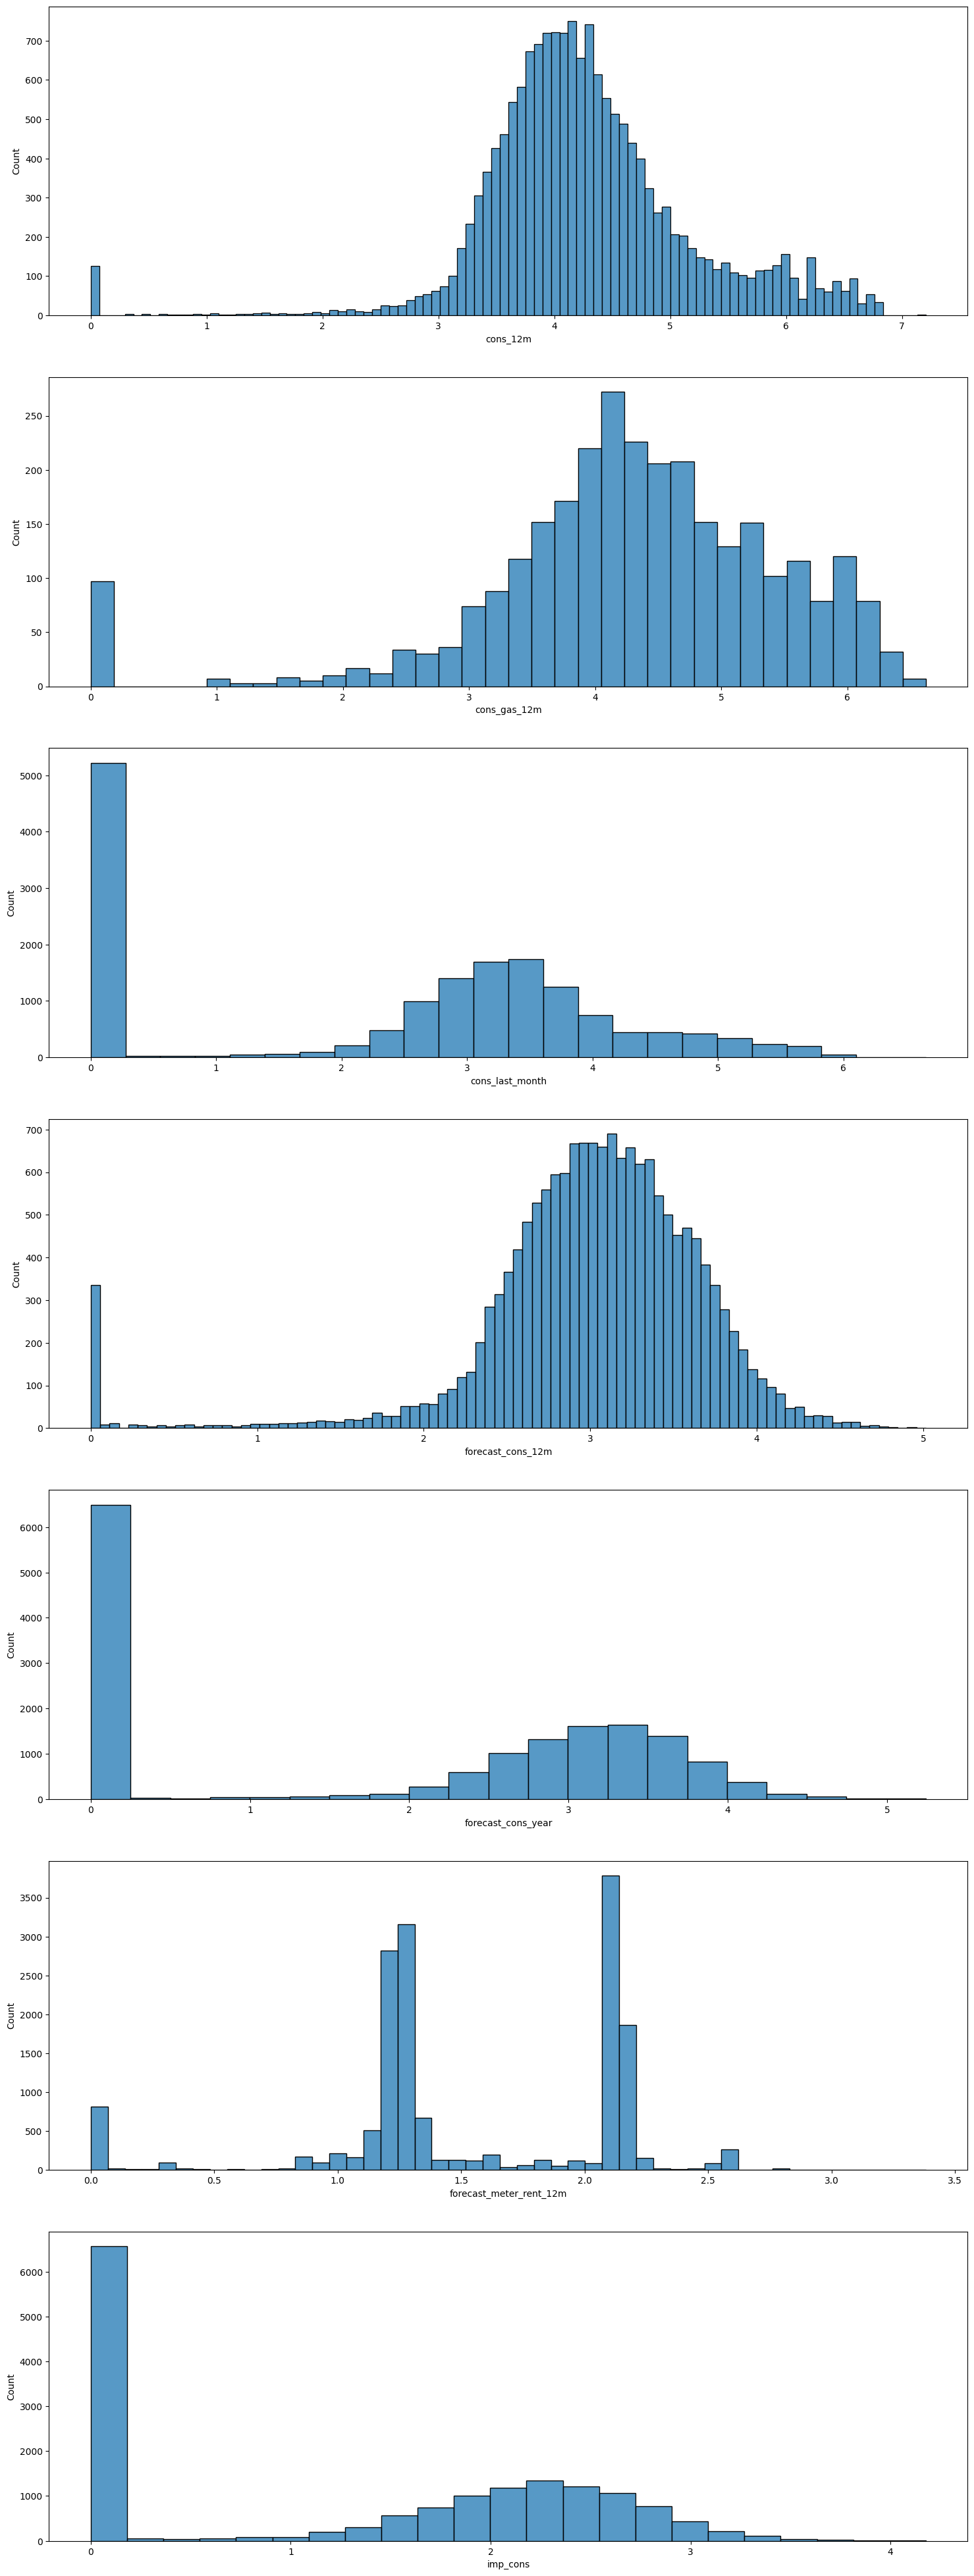

In [50]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot histograms
sns.histplot((train["cons_12m"].dropna()), ax=axs[0])
sns.histplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.histplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.histplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.histplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.histplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.histplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

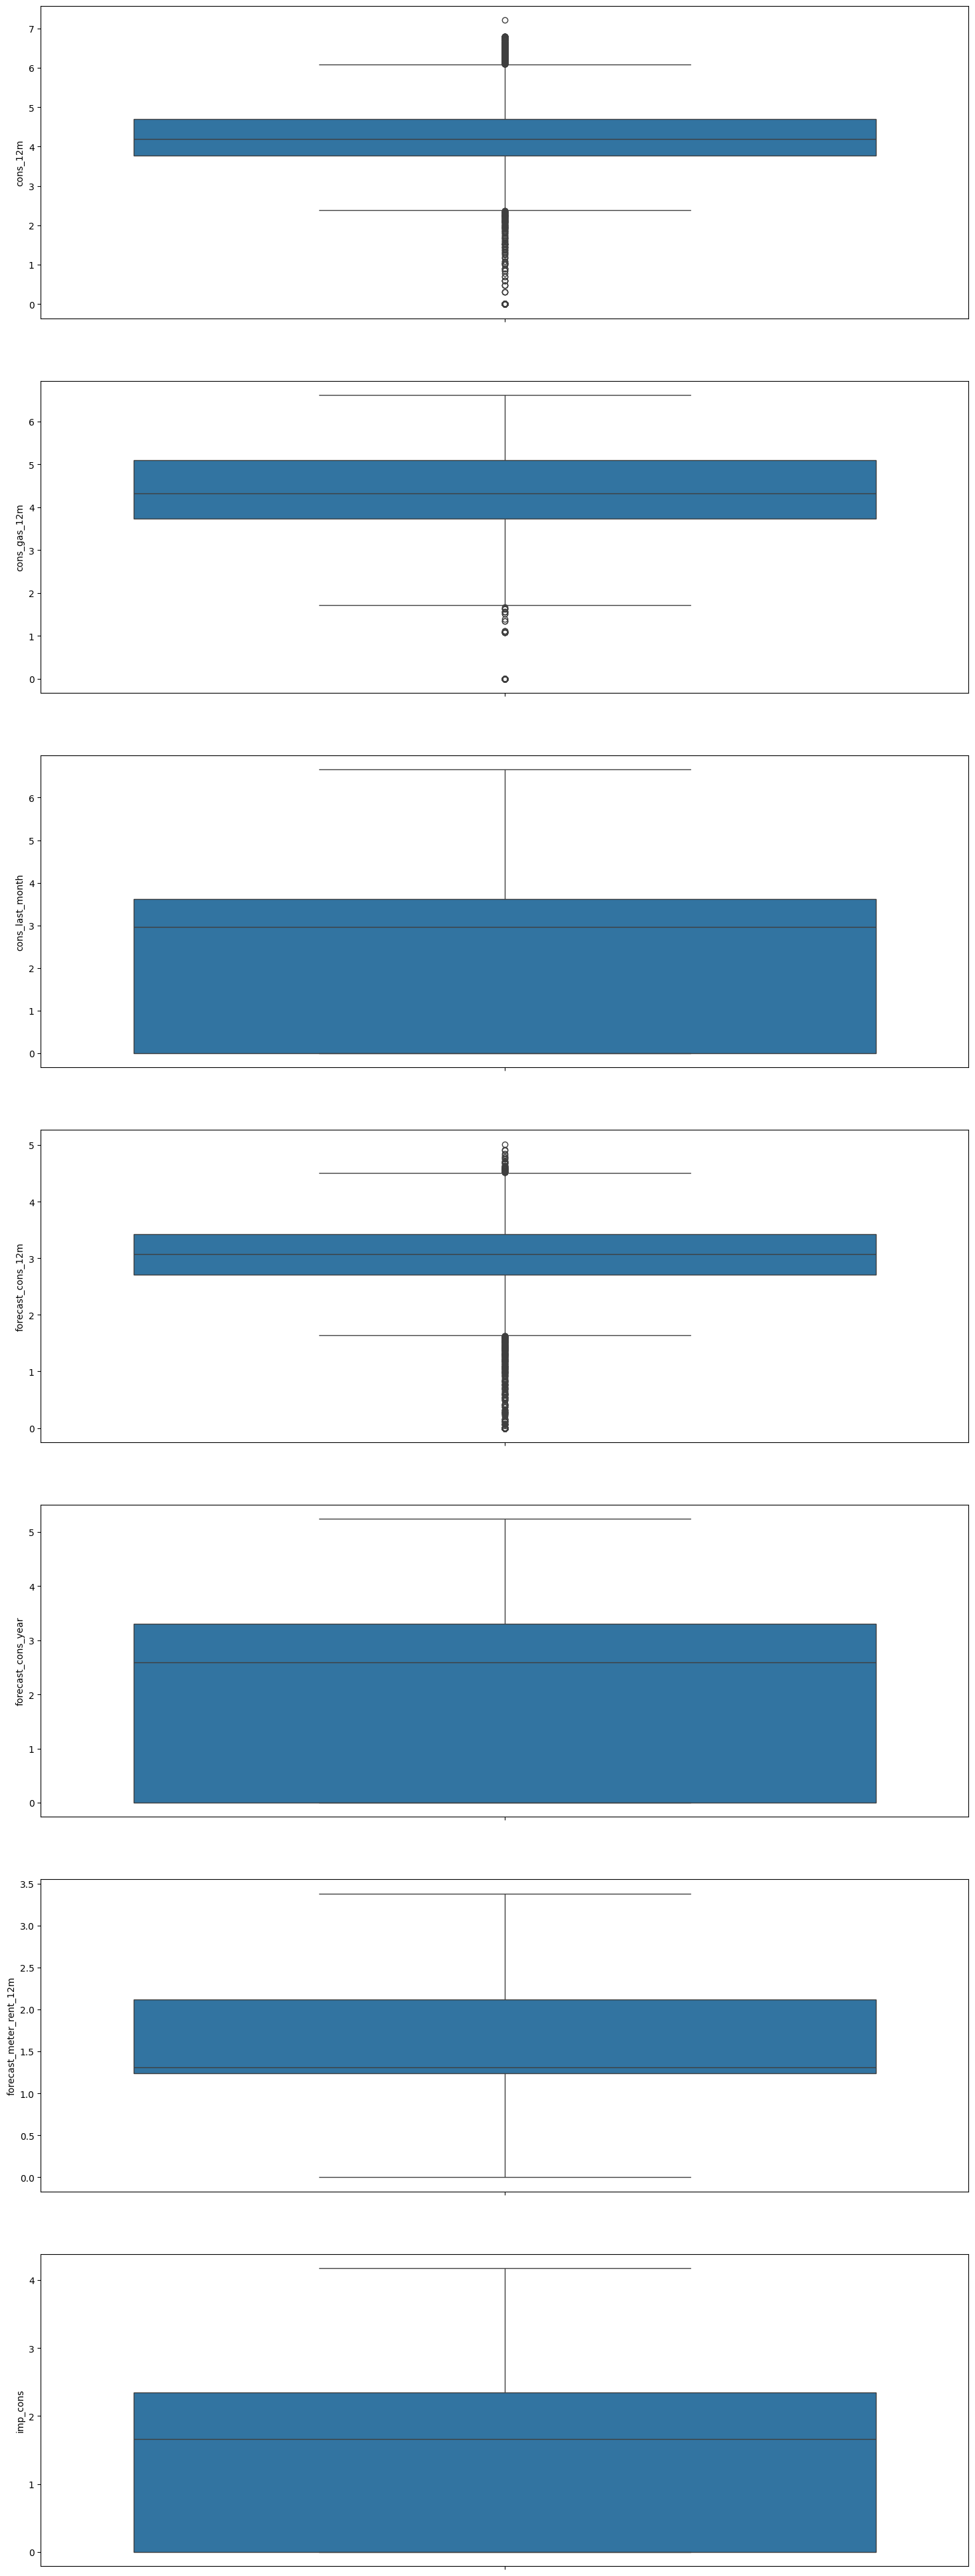

In [51]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [52]:
train.describe()

,Unnamed: 0,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,...,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,8047.500000,4.282194,0.801172,2.363565,3.005280,1.872138,0.983785,1.549584,0.135955,0.053211,...,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,4646.659302,0.916325,1.749100,1.788942,0.711183,1.612967,5.141470,0.589479,0.026157,0.048515,...,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4023.750000,3.772670,0.000000,0.000000,2.712418,0.000000,0.000000,1.236285,0.115237,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8047.500000,4.186589,0.000000,2.963316,3.072996,2.586587,0.000000,1.310481,0.142881,0.086163,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12071.250000,4.701050,0.000000,3.619745,3.430811,3.301518,0.000000,2.122126,0.146348,0.098837,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16095.000000,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The distributions look much closer to normal distributions now!

Notice how the standard deviation std has changed.

From the boxplots we can still see some values are quite far from the range ( outliers ). We will deal with them later.

### 2. High correlation variables

In [54]:
features

,id,Unnamed: 0,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,0002203ffbb812588b632b9e628cc38d,72168.5,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
1,0004351ebdd665e6ee664792efc4fd13,157114.5,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,168215.5,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,51909.5,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003
4,00114d74e963e47177db89bc70108537,24565.5,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,187199.5,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,41.035291,24.752581,16.588752
16092,fffac626da707b1b5ab11e8431a4d0a2,35382.5,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,44.458512,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,1851.5,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,41.314049,25.025265,16.858411
16094,fffe4f5646aa39c7f97f95ae2679ce64,141255.5,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,40.730558,24.467516,16.316414


In [55]:
# Calculate correlation of variables
numeric_features = features.select_dtypes(include=[np.number])  # Select only numeric columns
correlation = numeric_features.corr()


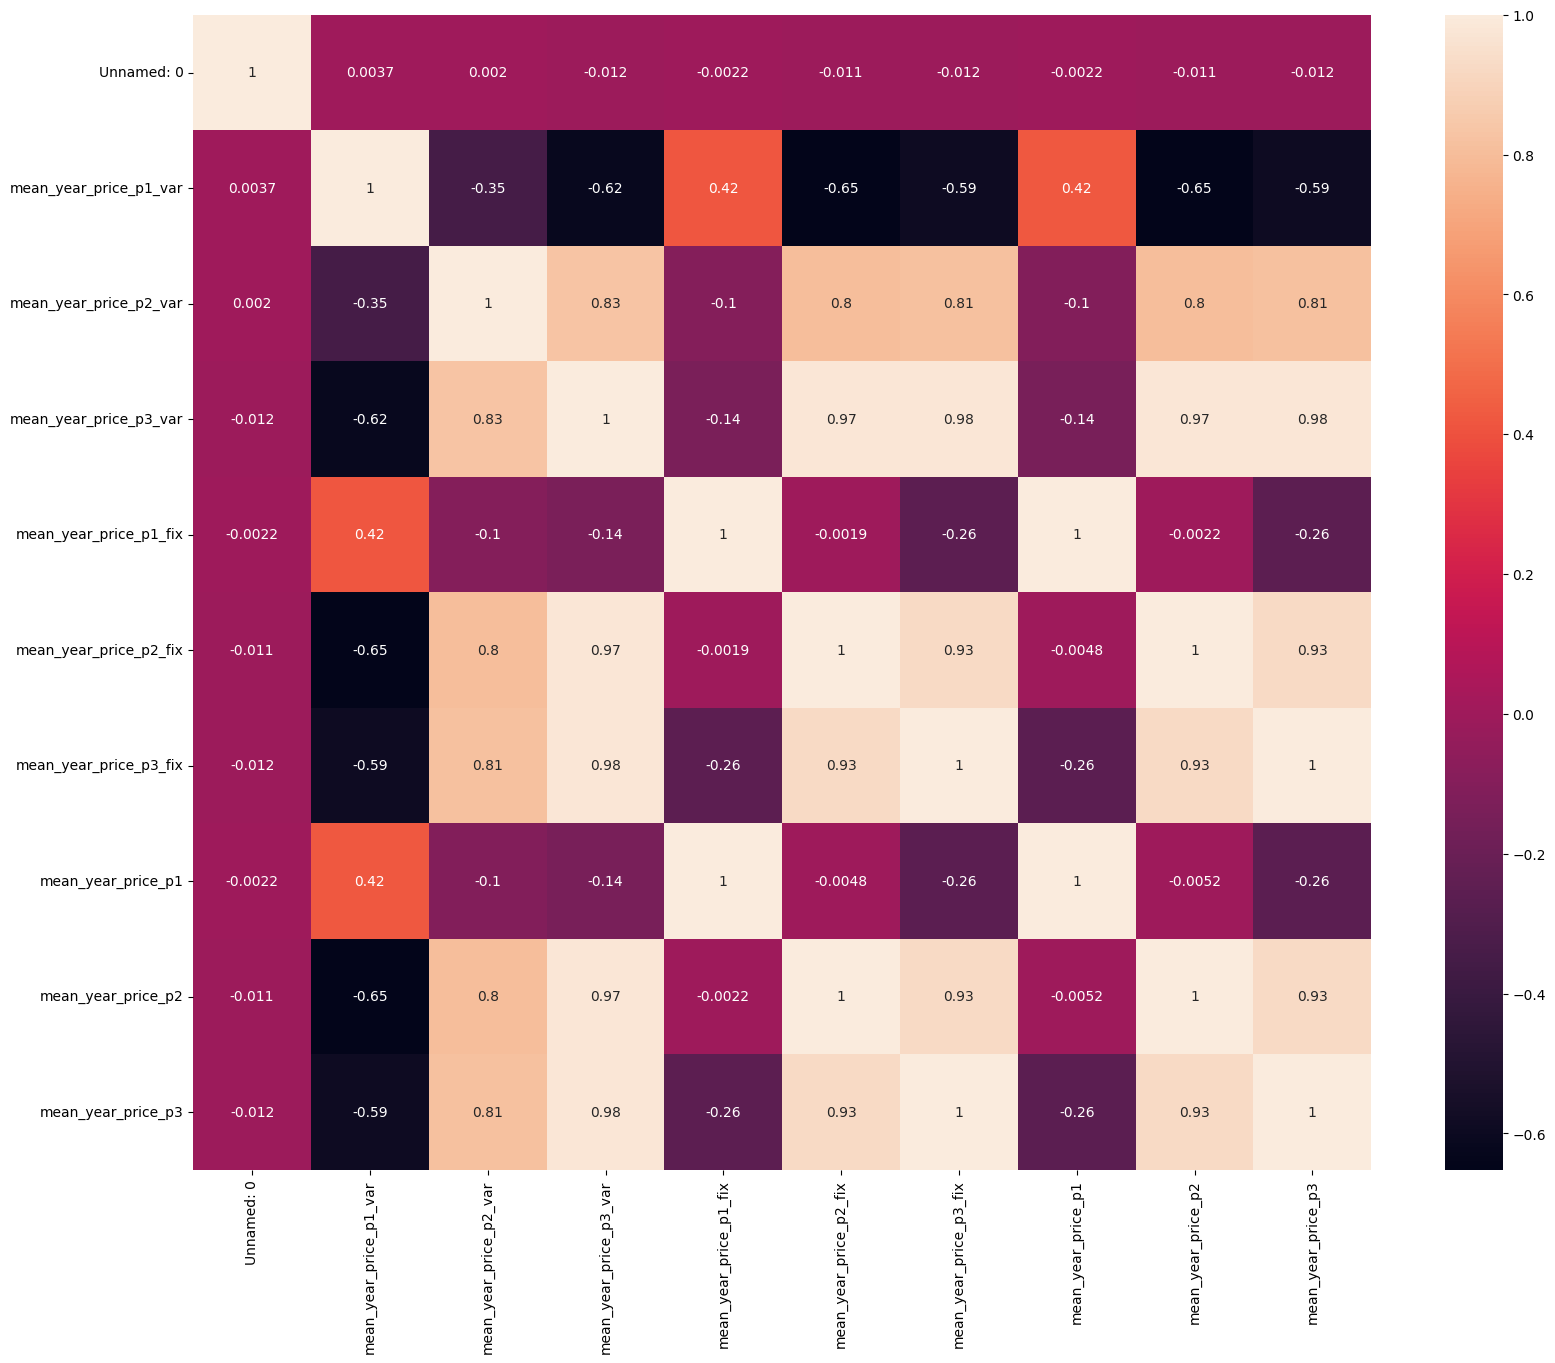

In [56]:
# Plot correlation
plt.figure(figsize=(19,15))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

We can remove highly correlated variables.

Multicollinearity happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of
accuracy. This can lead to skewed or misleading results. Luckily, decision trees and boosted trees algorithms are immune to multicollinearity by
nature. When they decide to split, the tree will choose only one of the perfectly correlated features. However, other algorithms like Logistic Regression or Linear Regression are not immune to that problem and should be fixed before training the model.

In [59]:
# Calculate correlation of variables
numeric_train = train.select_dtypes(include=[np.number])
correlation = numeric_train.corr()

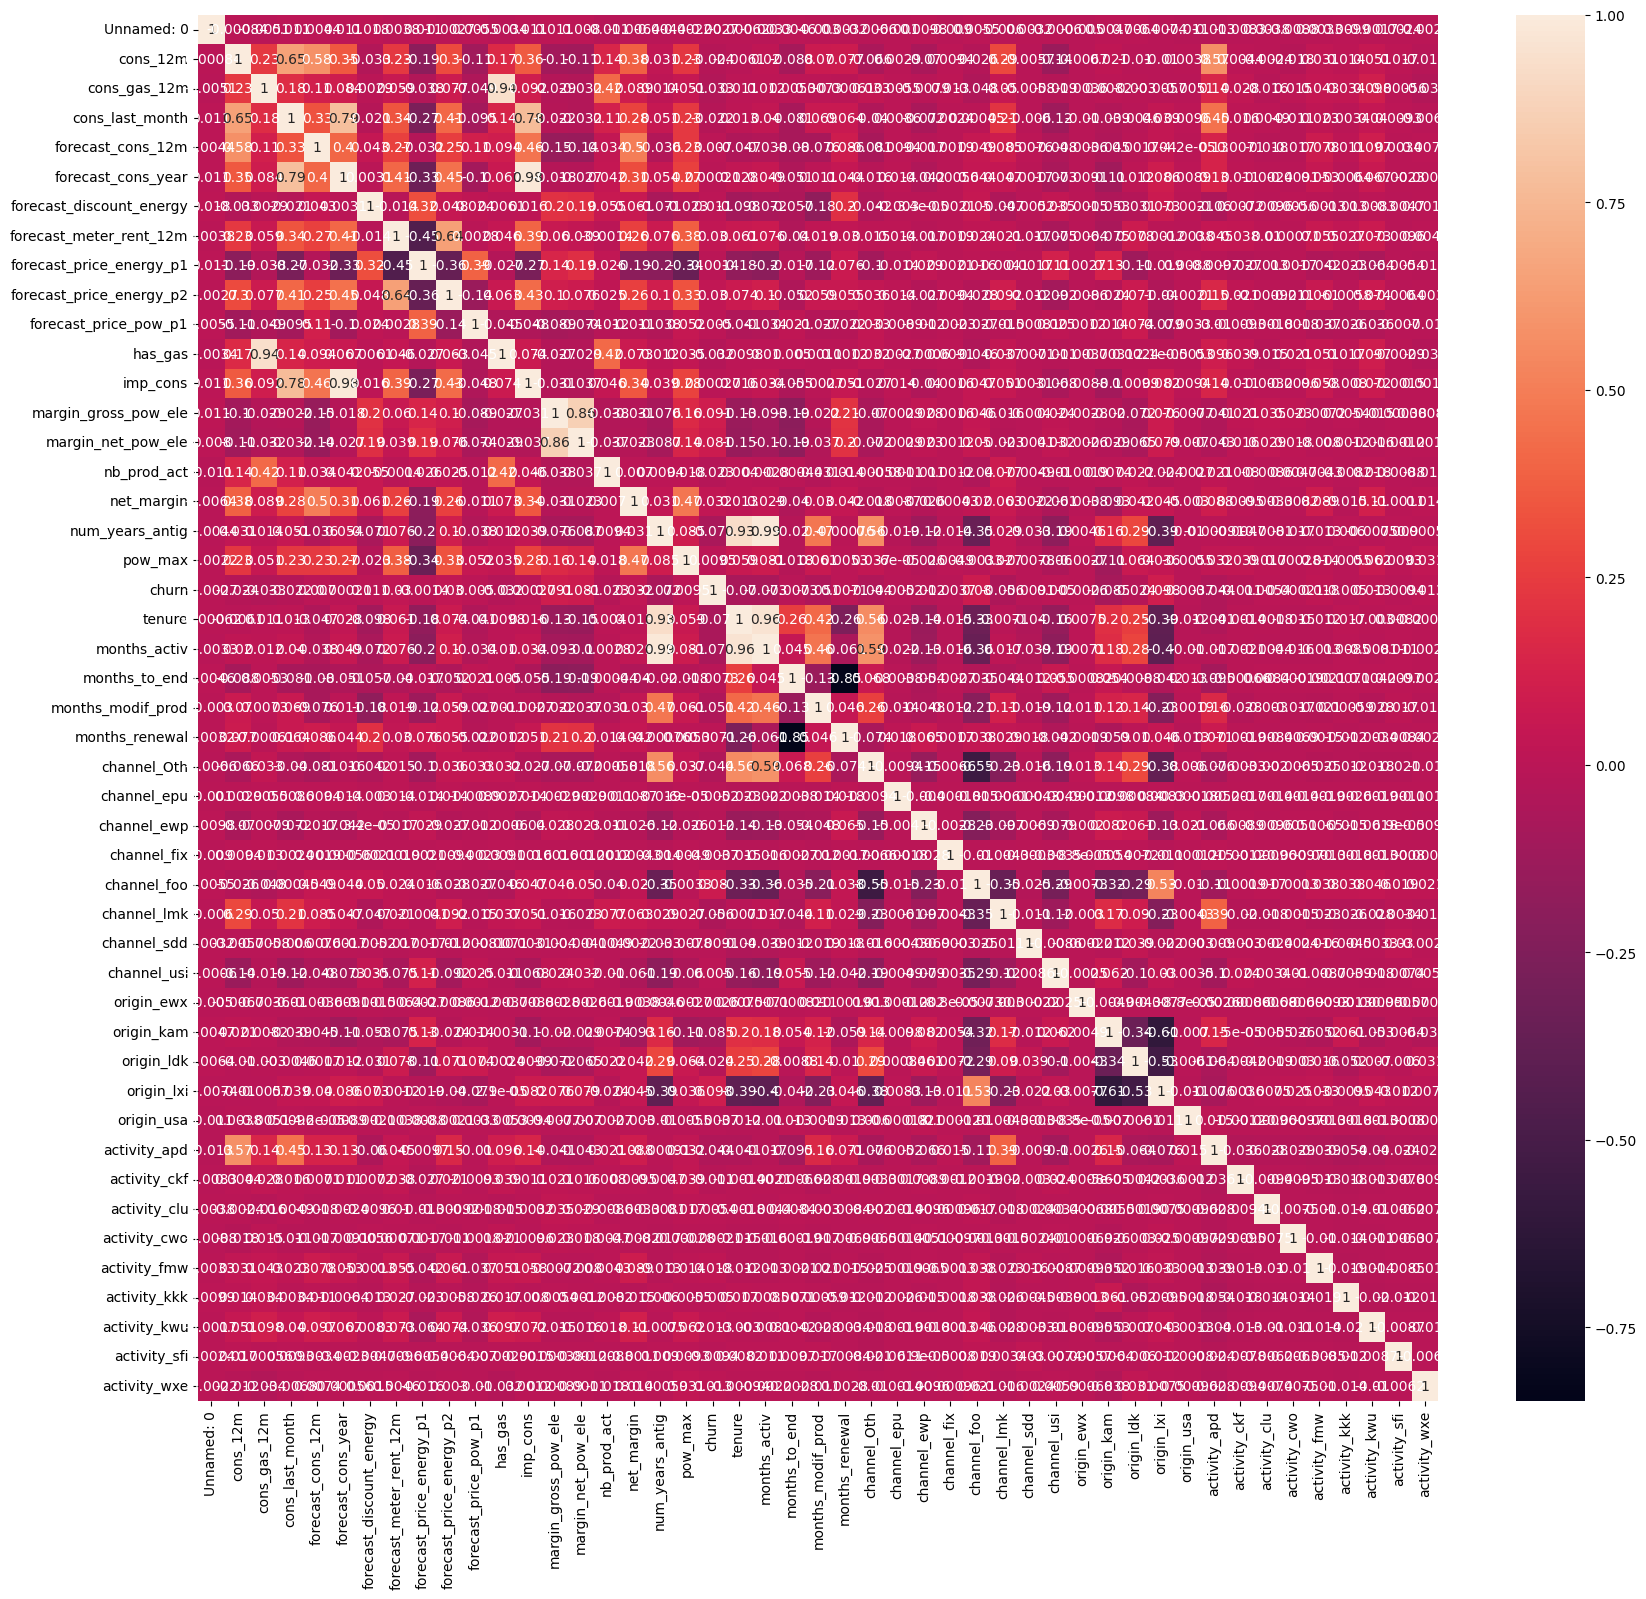

In [60]:
# Plot correlation
plt.figure(figsize=(20,18))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

As expected, num_years_antig has a high correlation with months_activ (it provides us the same information).
We can remove variables with very high correlation

In [61]:
train.drop(columns=["num_years_antig", "forecast_cons_year"],inplace=True)

### Removing outliers
As we identified during the exploratory phase, the consumption data has several outliers. We are going to remove those outliers
What are the criteria to identify an outlier?
The most common way to identify an outlier are:
1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
OR
2. Data point that falls outside of 3 standard deviations.
Once, we have identified the outlier, What do we do with the outliers?
There are several ways to handle with those outliers such as removing them (this works well for massive datasets) or replacing them with sensible data
(works better when the dataset is not that big).
We will replace the outliers with the mean (average of the values excluding outliers)

In [63]:
def replace_outliers_z_score(dataframe, column, Z=3):
    """
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with the mean values.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column
    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    # Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()
    # Replace with mean values
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_
    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [64]:
for c in features.columns:
    if c != "id":
        features = replace_outliers_z_score(features,c)

Replaced: 0  outliers in  Unnamed: 0
Replaced: 276  outliers in  mean_year_price_p1_var
Replaced: 0  outliers in  mean_year_price_p2_var
Replaced: 0  outliers in  mean_year_price_p3_var
Replaced: 120  outliers in  mean_year_price_p1_fix
Replaced: 0  outliers in  mean_year_price_p2_fix
Replaced: 0  outliers in  mean_year_price_p3_fix
Replaced: 122  outliers in  mean_year_price_p1
Replaced: 0  outliers in  mean_year_price_p2
Replaced: 0  outliers in  mean_year_price_p3


In [65]:
features.reset_index(drop=True, inplace=True)

As we identified during the exploratory phase, and when carrying out the log transformation , the dataset has several outliers.
What are the criteria to identify an outlier?
The most common way to identify an outlier are:
1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
OR
2. Data point that falls outside of 3 standard deviations.
Once, we have identified the outlier, What do we do with the outliers?
There are several ways to handle with those outliers such as removing them (this works well for massive datasets) or replacing them with sensible data
(works better when the dataset is not that big).
We will replace the outliers with the mean (average of the values excluding outliers).

In [66]:
def _find_outliers_iqr(dataframe, column):
    """
    Find outliers using the 1.5*IQR rule.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column
    Returns
    -------
    Dict
    With the values of the iqr, lower_bound and upper_bound
    """
    col = sorted(dataframe[column])
    q1, q3= np.percentile(col,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr)
    upper_bound = q3 +(1.5 * iqr)
    results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
    return results
def remove_outliers_iqr(dataframe, column):
    """
    Remove outliers using the 1.5*IQR rule.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column
    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    outliers = _find_outliers_iqr(dataframe, column)
    removed = dataframe[(dataframe[column] < outliers["lower_bound"]) |
    (dataframe[column] > outliers["upper_bound"])].shape
    dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) &
    (dataframe[column] < outliers["upper_bound"])]
    print("Removed:", removed[0], " outliers")
    return dataframe
    
def remove_outliers_z_score(dataframe, column, Z=3):
    """
    Remove outliers using the Z score. Values with more than 3 are removed.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column
    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore
    dataframe["zscore"] = zscore(dataframe[column])
    removed = dataframe[(dataframe["zscore"] < -Z) |
    (dataframe["zscore"] > Z)].shape
    dataframe = dataframe[(dataframe["zscore"] > -Z) &
    (dataframe["zscore"] < Z)]
    print("Removed:", removed[0], " outliers of ", column)
    return dataframe.drop(columns="zscore")

def replace_outliers_z_score(dataframe, column, Z=3):
    """
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with the mean values.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column
    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    # Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()
    # Replace with mean values
    no_outliers = dataframe[column].isnull().sum()
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_
    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [67]:
train = replace_outliers_z_score(train,"cons_12m")
train = replace_outliers_z_score(train,"cons_gas_12m")
train = replace_outliers_z_score(train,"cons_last_month")
train = replace_outliers_z_score(train,"forecast_cons_12m")
#train = replace_outliers_z_score(train,"forecast_cons_year")
train = replace_outliers_z_score(train,"forecast_discount_energy")
train = replace_outliers_z_score(train,"forecast_meter_rent_12m")
train = replace_outliers_z_score(train,"forecast_price_energy_p1")
train = replace_outliers_z_score(train,"forecast_price_energy_p2")
train = replace_outliers_z_score(train,"forecast_price_pow_p1")
train = replace_outliers_z_score(train,"imp_cons")
train = replace_outliers_z_score(train,"margin_gross_pow_ele")
train = replace_outliers_z_score(train,"margin_net_pow_ele")
train = replace_outliers_z_score(train,"net_margin")
train = replace_outliers_z_score(train,"pow_max")
train = replace_outliers_z_score(train,"months_activ")
train = replace_outliers_z_score(train,"months_to_end")
train = replace_outliers_z_score(train,"months_modif_prod")
train = replace_outliers_z_score(train,"months_renewal")

Replaced: 0  outliers in  cons_12m
Replaced: 0  outliers in  cons_gas_12m
Replaced: 0  outliers in  cons_last_month
Replaced: 0  outliers in  forecast_cons_12m
Replaced: 0  outliers in  forecast_discount_energy
Replaced: 0  outliers in  forecast_meter_rent_12m
Replaced: 0  outliers in  forecast_price_energy_p1
Replaced: 0  outliers in  forecast_price_energy_p2
Replaced: 0  outliers in  forecast_price_pow_p1
Replaced: 0  outliers in  imp_cons
Replaced: 13  outliers in  margin_gross_pow_ele
Replaced: 13  outliers in  margin_net_pow_ele
Replaced: 15  outliers in  net_margin
Replaced: 3  outliers in  pow_max
Replaced: 0  outliers in  months_activ
Replaced: 0  outliers in  months_to_end
Replaced: 0  outliers in  months_modif_prod
Replaced: 0  outliers in  months_renewal


C:\Users\tramn\AppData\Local\Temp\ipykernel_4780\545789981.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.76007419726238' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_
C:\Users\tramn\AppData\Local\Temp\ipykernel_4780\545789981.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.3862930284578105' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_
C:\Users\tramn\AppData\Local\Temp\ipykernel_4780\545789981.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.74190715181932' has dtype

In [68]:
train.reset_index(drop=True, inplace=True)

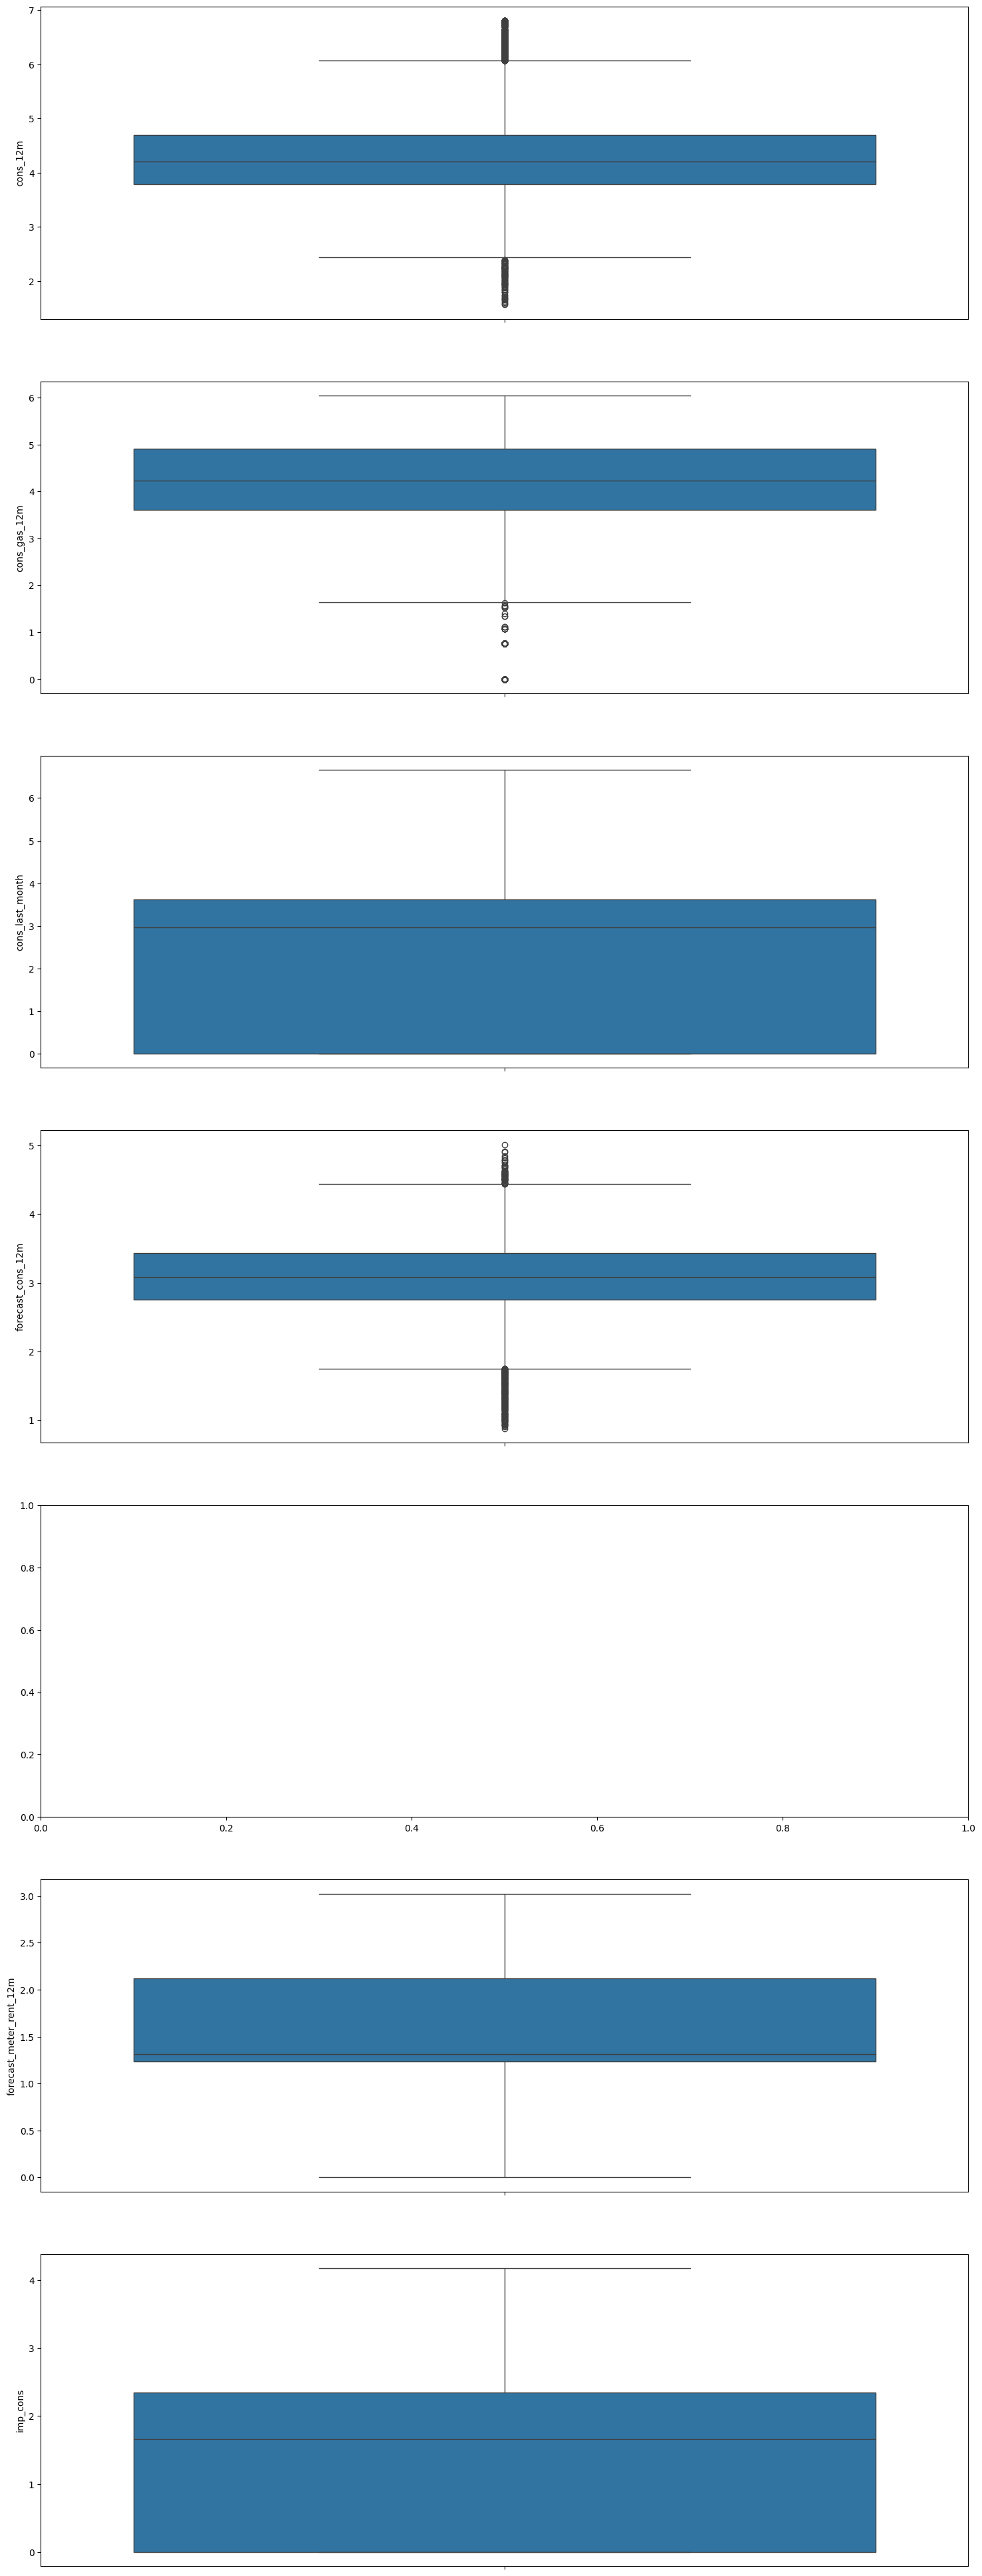

In [69]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
#sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [ ]:
pd.to_csv('train_data.csv')